2023-12-10 13:07:45,760 - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteocarucci2 (devops_project). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: kiiokuc4
Sweep URL: https://wandb.ai/devops_project/Customer_Segmentation/sweeps/kiiokuc4


wandb: Agent Starting Run: l2z3338r with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 3
wandb: 	random_state: 42
Exception in thread Exception in thread ChkStopThrNetStatThr:
:
Traceback (most recent call last):
Traceback (most recent call last):
  File "c:\Users\39339\anaconda3\envs\devops_env\Lib\threading.py", line 1038, in _bootstrap_inner
  File "c:\Users\39339\anaconda3\envs\devops_env\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\39339\anaconda3\envs\devops_env\Lib\threading.py", line 975, in run
    self.run()
  File "c:\Users\39339\anaconda3\envs\devops_env\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\wandb\sdk\wandb_run.py", line 285, in check_stop_status
    self._target(*self._args, **self._kwargs)
  File "c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\wandb\sdk\wandb_run.py", line 267, in check_network_status
    se

2023-12-10 13:08:07,905 - INFO - Preparing data...
2023-12-10 13:08:08,166 - INFO - Data prepared successfully.
2023-12-10 13:08:08,169 - INFO - Dropping customer id...
2023-12-10 13:08:08,184 - INFO - Customer id dropped successfully.
2023-12-10 13:08:08,186 - INFO - Cleaning data...
2023-12-10 13:08:08,196 - INFO - Data cleaned successfully.
2023-12-10 13:08:08,198 - INFO - Computing frequencies.
2023-12-10 13:08:08,208 - INFO - Computing monetary values.
2023-12-10 13:08:08,213 - INFO - Computing recency.
2023-12-10 13:08:08,241 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:08:08,246 - INFO - Dataframes concatenated successfully.
2023-12-10 13:08:08,247 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of

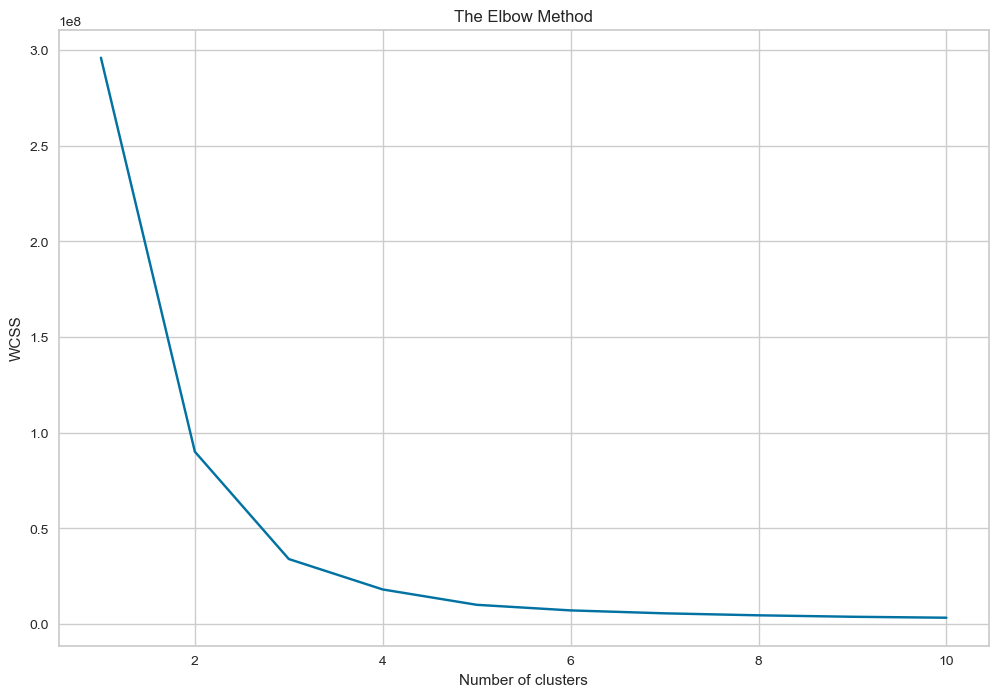

2023-12-10 13:08:20,395 - INFO - Elbow Method completed
2023-12-10 13:08:20,397 - INFO - Saving Inertia and combined score
2023-12-10 13:08:20,479 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.19301
Inertia,3313765.55634


2023-12-10 13:08:28,492 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
2023-12-10 13:08:28,581 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


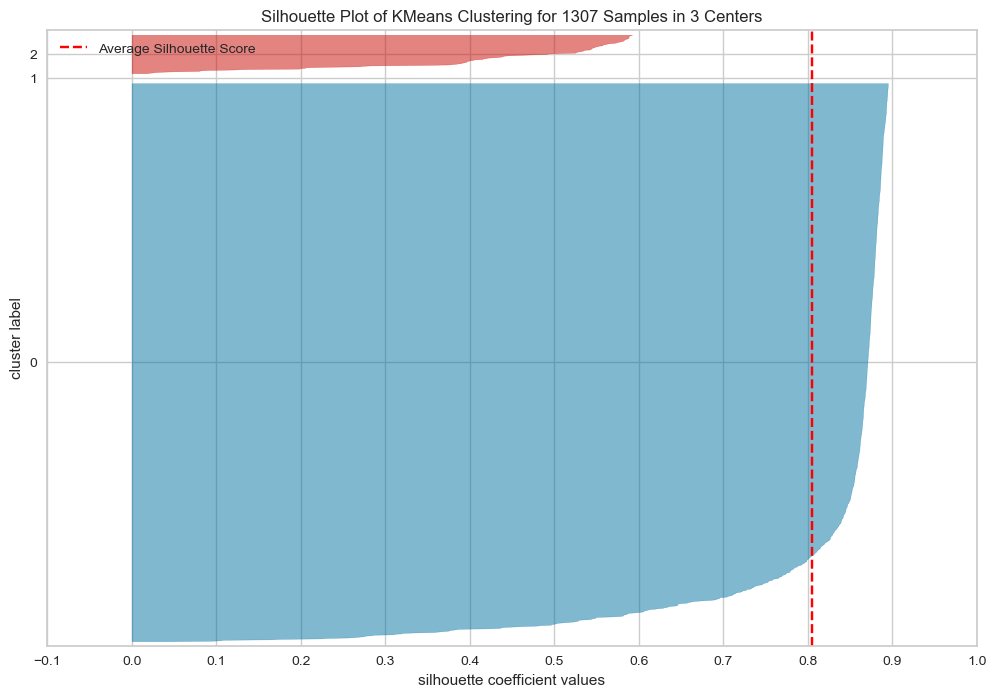

2023-12-10 13:08:29,572 - INFO - Clustering completed
2023-12-10 13:08:29,574 - INFO - Starting plot_clusters function...
2023-12-10 13:08:29,826 - INFO - Saving clusters plot...
2023-12-10 13:08:32,346 - INFO - Cluster plotting completed.
2023-12-10 13:08:32,347 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,3
Silhouette Score,0.80525


wandb: Agent Starting Run: 345ja3v4 with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 3
wandb: 	random_state: 123
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:08:53,756 - INFO - Preparing data...
2023-12-10 13:08:54,050 - INFO - Data prepared successfully.
2023-12-10 13:08:54,053 - INFO - Dropping customer id...
2023-12-10 13:08:54,076 - INFO - Customer id dropped successfully.
2023-12-10 13:08:54,078 - INFO - Cleaning data...
2023-12-10 13:08:54,099 - INFO - Data cleaned successfully.
2023-12-10 13:08:54,104 - INFO - Computing frequencies.
2023-12-10 13:08:54,114 - INFO - Computing monetary values.
2023-12-10 13:08:54,119 - INFO - Computing recency.
2023-12-10 13:08:54,146 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:08:54,155 - INFO - Dataframes concatenated successfully.
2023-12-10 13:08:54,158 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:09:06,474 - INFO - Saved Elbow Method plot


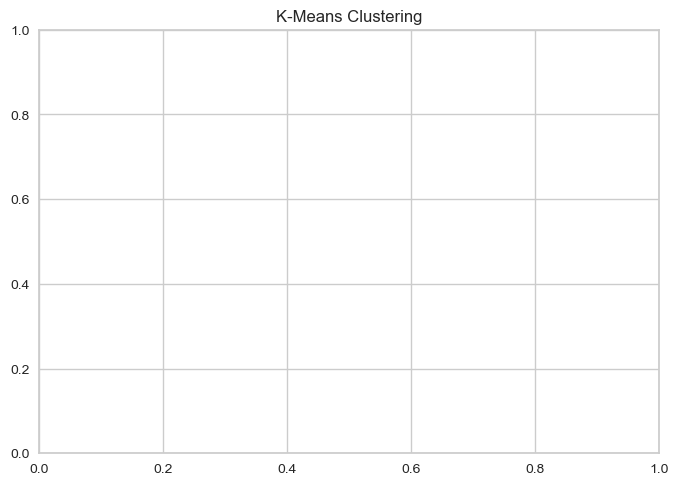

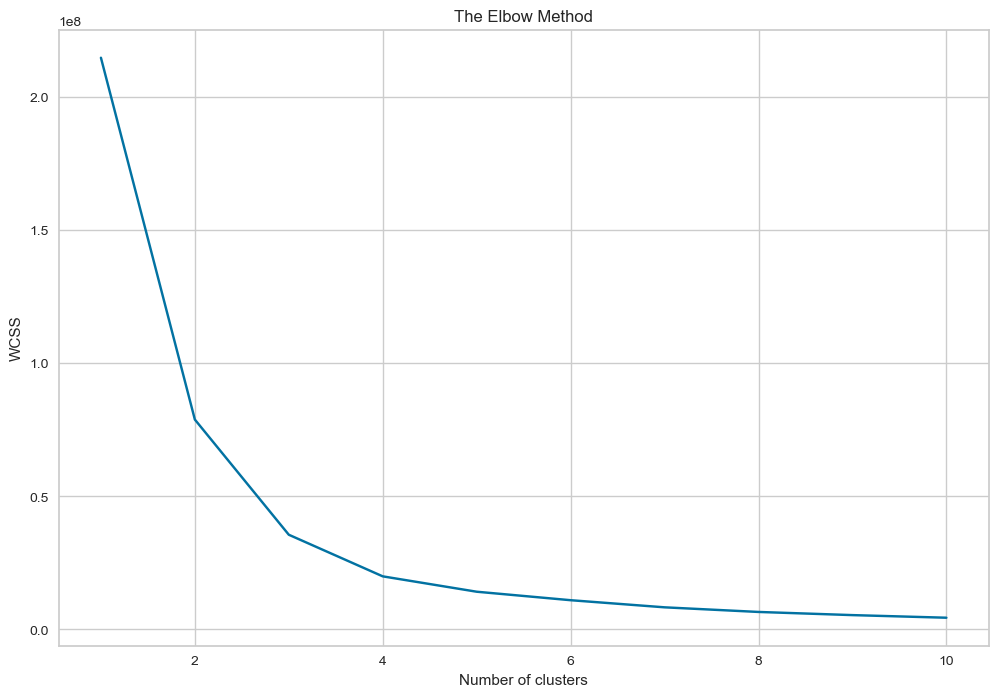

2023-12-10 13:09:07,141 - INFO - Elbow Method completed
2023-12-10 13:09:07,142 - INFO - Saving Inertia and combined score
2023-12-10 13:09:07,186 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.1976
Inertia,4406842.87347


2023-12-10 13:09:14,416 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

2023-12-10 13:09:14,445 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



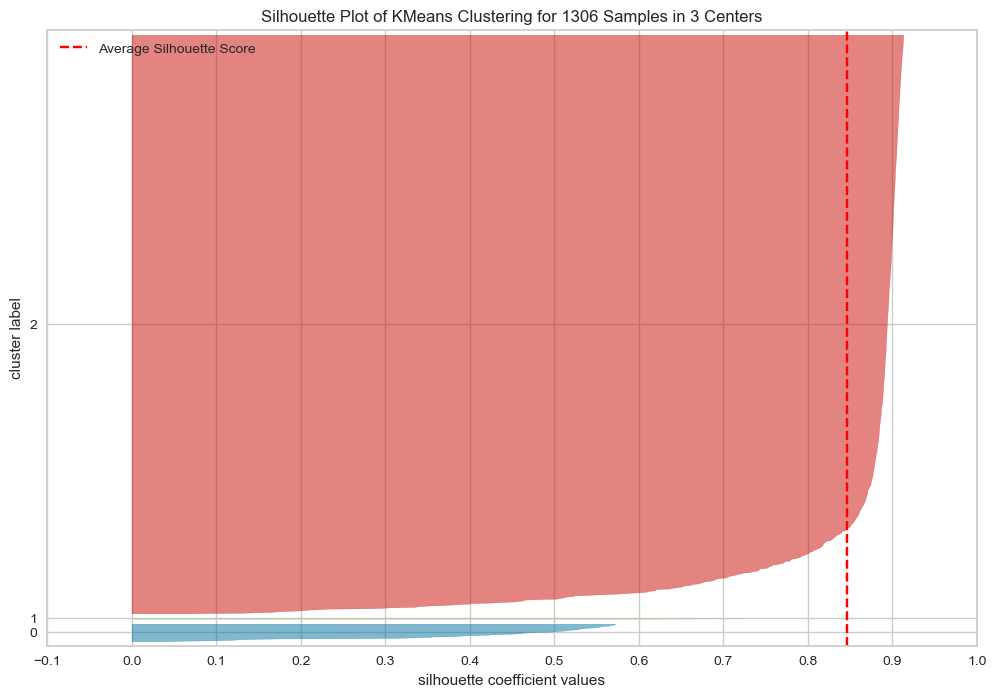

2023-12-10 13:09:15,084 - INFO - Clustering completed
2023-12-10 13:09:15,086 - INFO - Starting plot_clusters function...
2023-12-10 13:09:15,145 - INFO - Saving clusters plot...
2023-12-10 13:09:17,029 - INFO - Cluster plotting completed.
2023-12-10 13:09:17,030 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,3
Silhouette Score,0.84668


wandb: Agent Starting Run: z9j5jxes with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 3
wandb: 	random_state: 456
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:09:40,070 - INFO - Preparing data...
2023-12-10 13:09:40,510 - INFO - Data prepared successfully.
2023-12-10 13:09:40,512 - INFO - Dropping customer id...
2023-12-10 13:09:40,550 - INFO - Customer id dropped successfully.
2023-12-10 13:09:40,553 - INFO - Cleaning data...
2023-12-10 13:09:40,579 - INFO - Data cleaned successfully.
2023-12-10 13:09:40,585 - INFO - Computing frequencies.
2023-12-10 13:09:40,597 - INFO - Computing monetary values.
2023-12-10 13:09:40,612 - INFO - Computing recency.
2023-12-10 13:09:40,656 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:09:40,674 - INFO - Dataframes concatenated successfully.
2023-12-10 13:09:40,678 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:09:54,767 - INFO - Saved Elbow Method plot


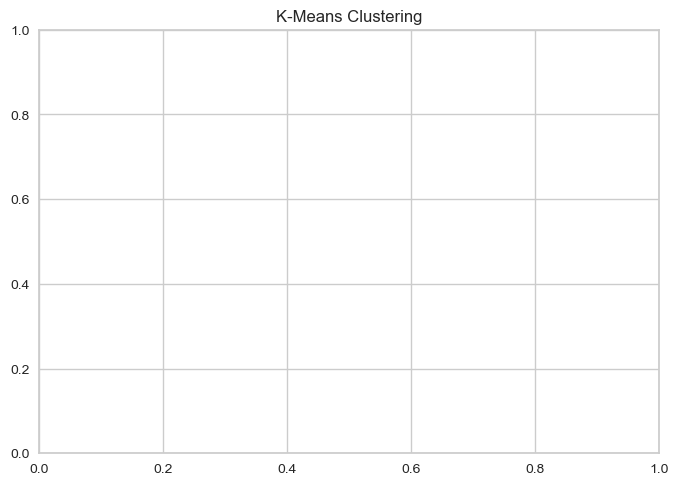

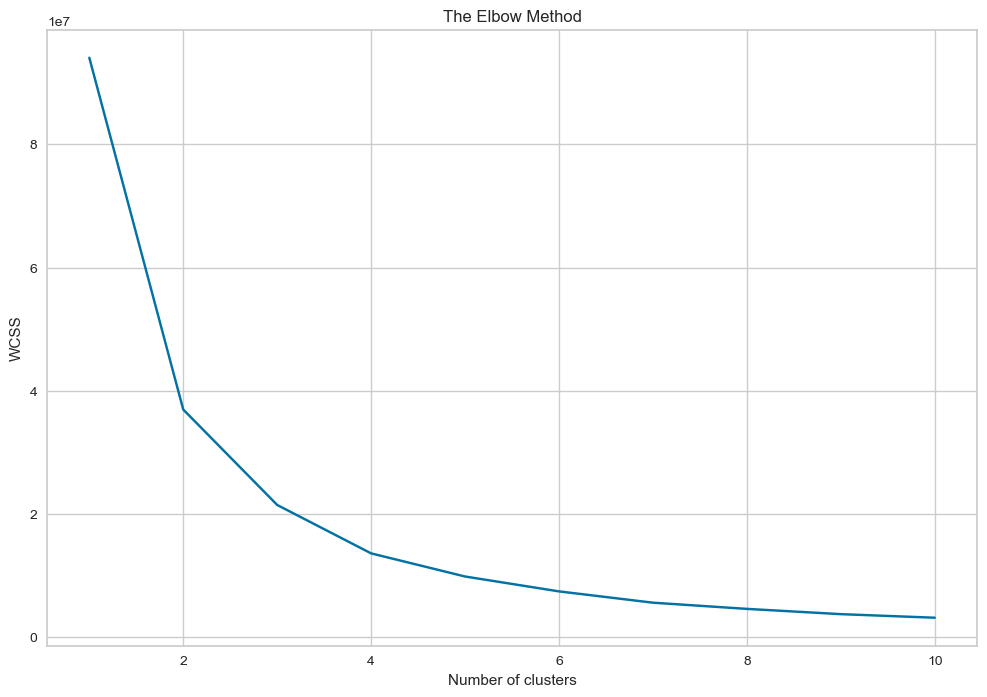

2023-12-10 13:09:56,005 - INFO - Elbow Method completed
2023-12-10 13:09:56,007 - INFO - Saving Inertia and combined score
2023-12-10 13:09:56,070 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.18933
Inertia,3164534.30598


2023-12-10 13:10:02,866 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

2023-12-10 13:10:02,897 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



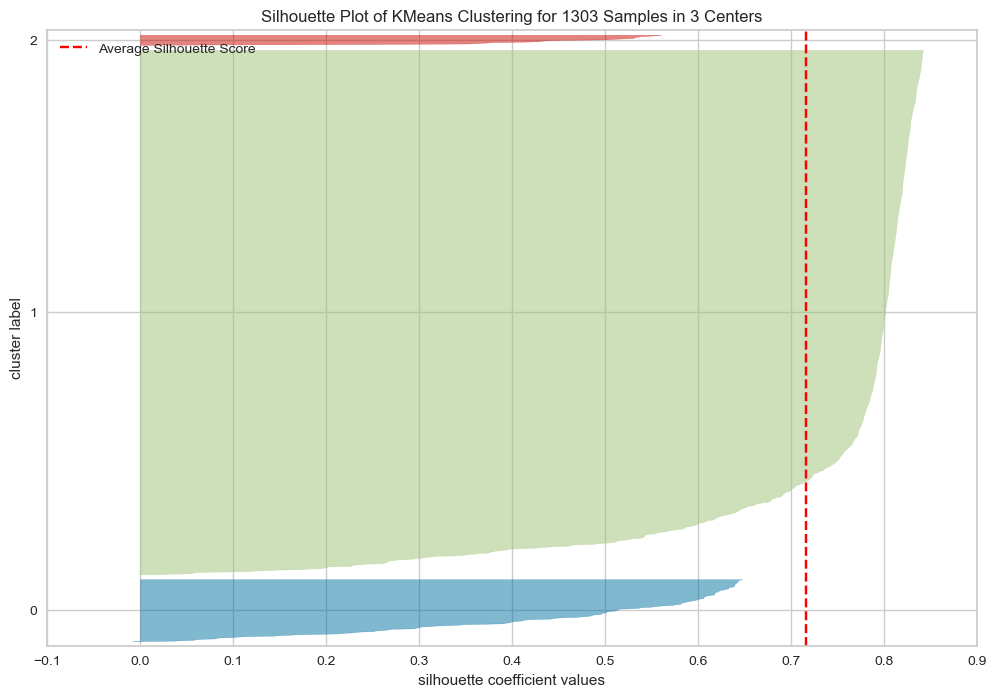

2023-12-10 13:10:03,597 - INFO - Clustering completed
2023-12-10 13:10:03,601 - INFO - Starting plot_clusters function...
2023-12-10 13:10:03,644 - INFO - Saving clusters plot...
2023-12-10 13:10:05,786 - INFO - Cluster plotting completed.
2023-12-10 13:10:05,787 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,3
Silhouette Score,0.71567


wandb: Agent Starting Run: z4835ctr with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 4
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:10:30,204 - INFO - Preparing data...
2023-12-10 13:10:30,817 - INFO - Data prepared successfully.
2023-12-10 13:10:30,820 - INFO - Dropping customer id...
2023-12-10 13:10:30,858 - INFO - Customer id dropped successfully.
2023-12-10 13:10:30,860 - INFO - Cleaning data...
2023-12-10 13:10:30,887 - INFO - Data cleaned successfully.
2023-12-10 13:10:30,892 - INFO - Computing frequencies.
2023-12-10 13:10:30,899 - INFO - Computing monetary values.
2023-12-10 13:10:30,906 - INFO - Computing recency.
2023-12-10 13:10:30,929 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:10:30,946 - INFO - Dataframes concatenated successfully.
2023-12-10 13:10:30,951 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:10:43,803 - INFO - Saved Elbow Method plot


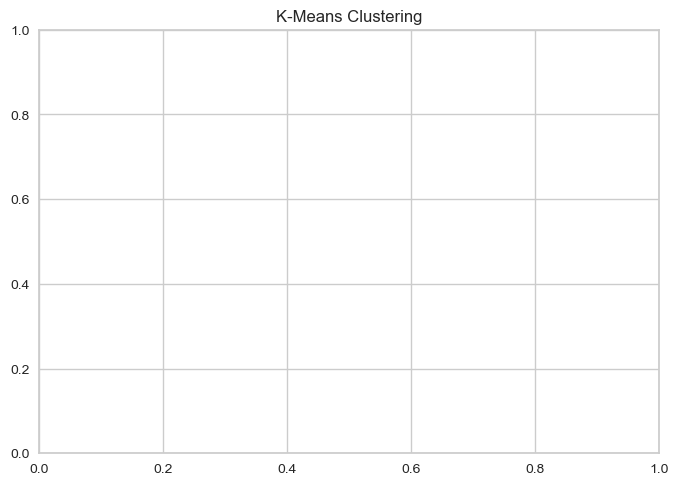

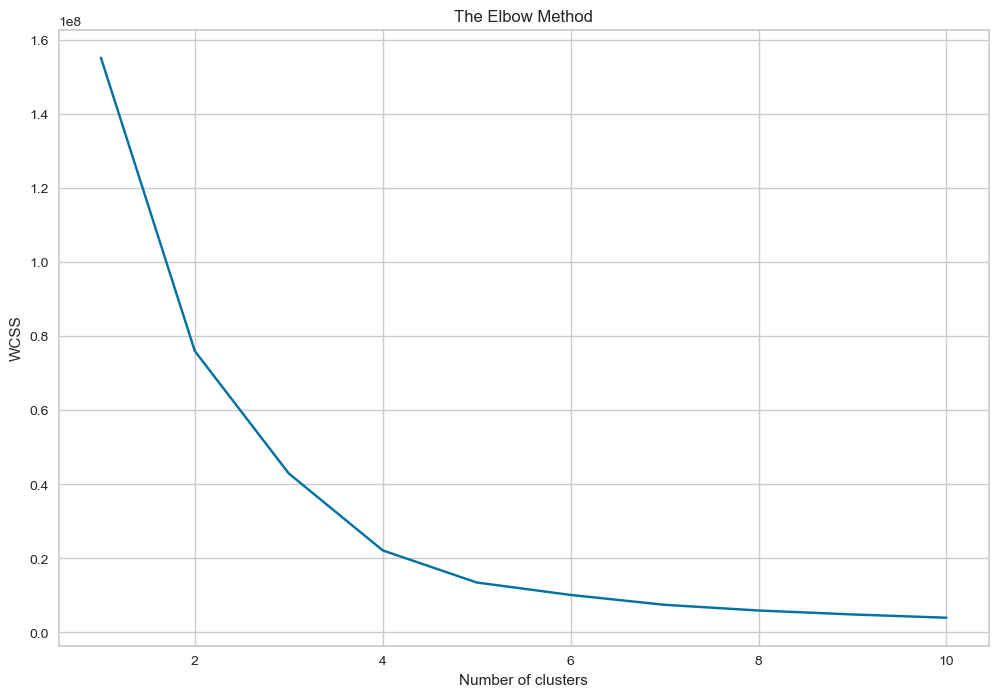

2023-12-10 13:10:45,113 - INFO - Elbow Method completed
2023-12-10 13:10:45,114 - INFO - Saving Inertia and combined score
2023-12-10 13:10:45,160 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.19869
Inertia,3980640.15062


2023-12-10 13:10:51,299 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

2023-12-10 13:10:51,325 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



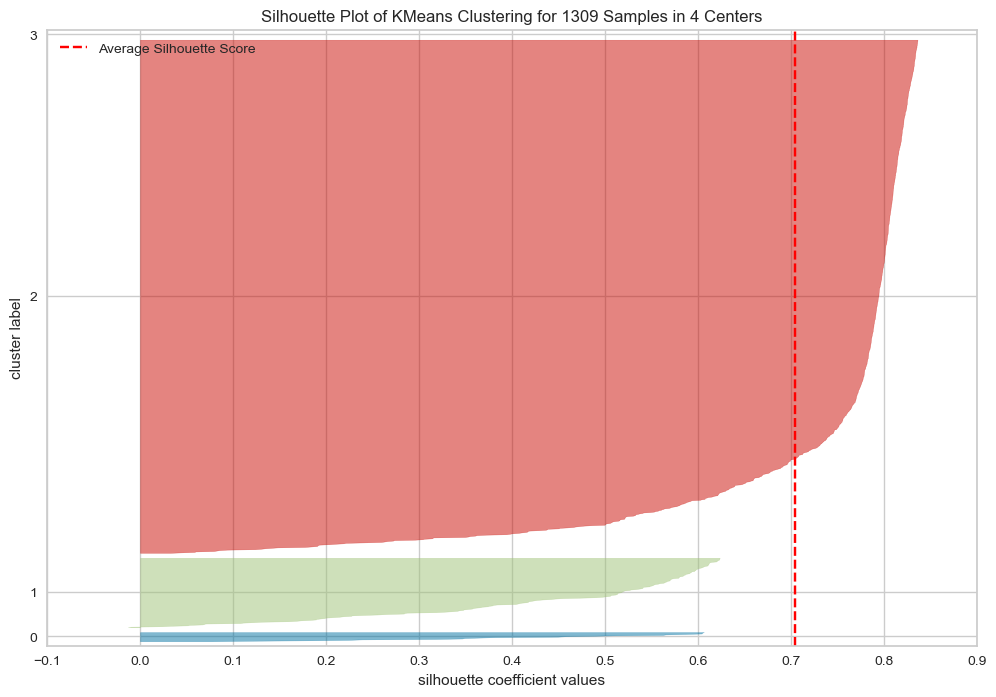

2023-12-10 13:10:52,351 - INFO - Clustering completed
2023-12-10 13:10:52,352 - INFO - Starting plot_clusters function...
2023-12-10 13:10:52,445 - INFO - Saving clusters plot...
2023-12-10 13:10:54,821 - INFO - Cluster plotting completed.
2023-12-10 13:10:54,823 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,4
Silhouette Score,0.70383


wandb: Agent Starting Run: 0w45xgbj with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 4
wandb: 	random_state: 123
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:11:18,728 - INFO - Preparing data...
2023-12-10 13:11:19,061 - INFO - Data prepared successfully.
2023-12-10 13:11:19,063 - INFO - Dropping customer id...
2023-12-10 13:11:19,077 - INFO - Customer id dropped successfully.
2023-12-10 13:11:19,078 - INFO - Cleaning data...
2023-12-10 13:11:19,093 - INFO - Data cleaned successfully.
2023-12-10 13:11:19,097 - INFO - Computing frequencies.
2023-12-10 13:11:19,102 - INFO - Computing monetary values.
2023-12-10 13:11:19,107 - INFO - Computing recency.
2023-12-10 13:11:19,128 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:11:19,135 - INFO - Dataframes concatenated successfully.
2023-12-10 13:11:19,137 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:11:32,420 - INFO - Saved Elbow Method plot


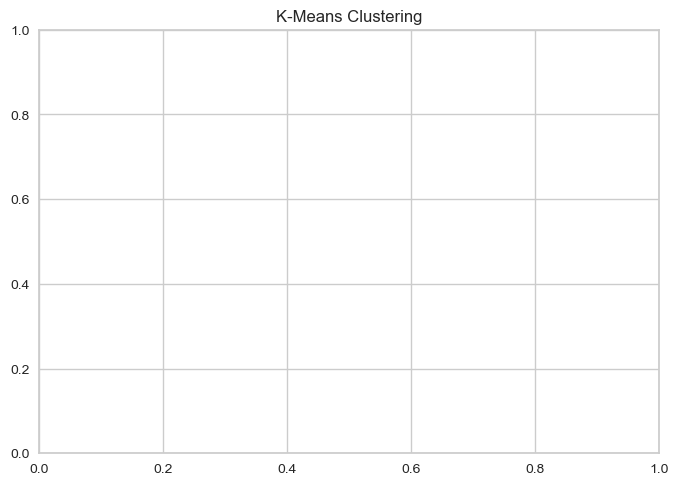

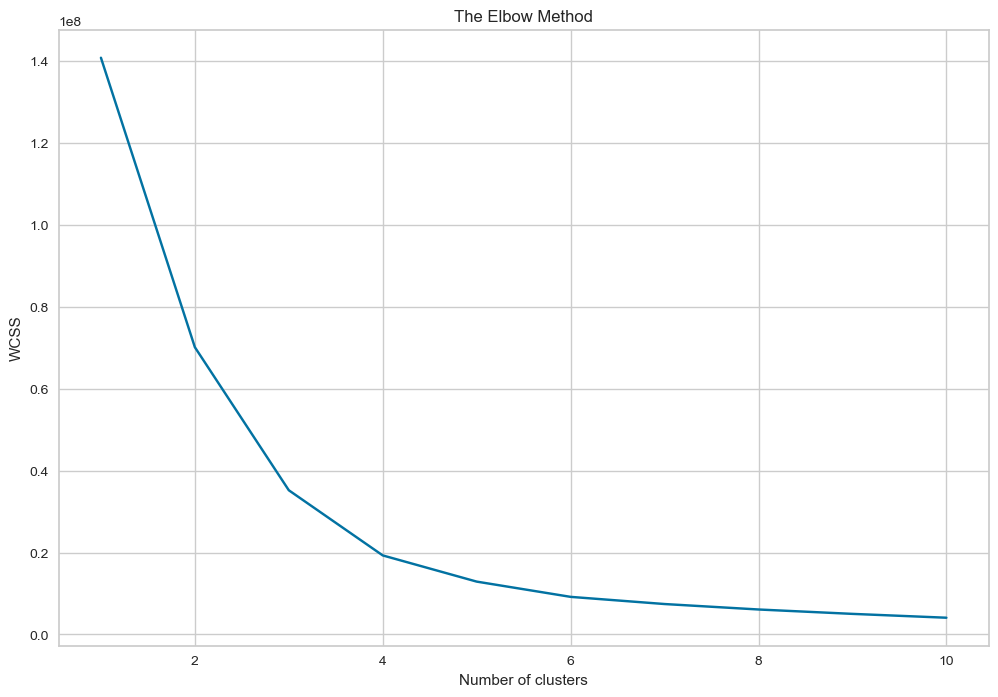

2023-12-10 13:11:33,476 - INFO - Elbow Method completed
2023-12-10 13:11:33,477 - INFO - Saving Inertia and combined score
2023-12-10 13:11:33,532 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.19768
Inertia,4090183.55612


2023-12-10 13:11:40,431 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

2023-12-10 13:11:40,477 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



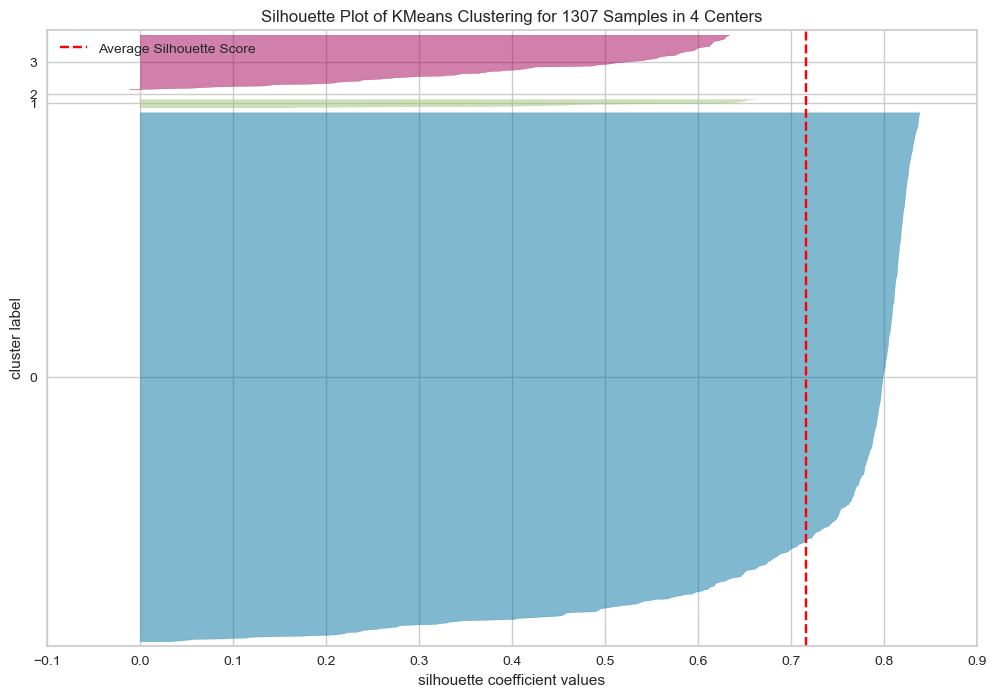

2023-12-10 13:11:41,480 - INFO - Clustering completed
2023-12-10 13:11:41,484 - INFO - Starting plot_clusters function...
2023-12-10 13:11:41,595 - INFO - Saving clusters plot...
2023-12-10 13:11:44,400 - INFO - Cluster plotting completed.
2023-12-10 13:11:44,402 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,4
Silhouette Score,0.7161


wandb: Agent Starting Run: mbh3toj7 with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 4
wandb: 	random_state: 456
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:12:05,322 - INFO - Preparing data...
2023-12-10 13:12:05,615 - INFO - Data prepared successfully.
2023-12-10 13:12:05,618 - INFO - Dropping customer id...
2023-12-10 13:12:05,642 - INFO - Customer id dropped successfully.
2023-12-10 13:12:05,643 - INFO - Cleaning data...
2023-12-10 13:12:05,663 - INFO - Data cleaned successfully.
2023-12-10 13:12:05,671 - INFO - Computing frequencies.
2023-12-10 13:12:05,683 - INFO - Computing monetary values.
2023-12-10 13:12:05,694 - INFO - Computing recency.
2023-12-10 13:12:05,726 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:12:05,734 - INFO - Dataframes concatenated successfully.
2023-12-10 13:12:05,736 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:12:16,761 - INFO - Saved Elbow Method plot


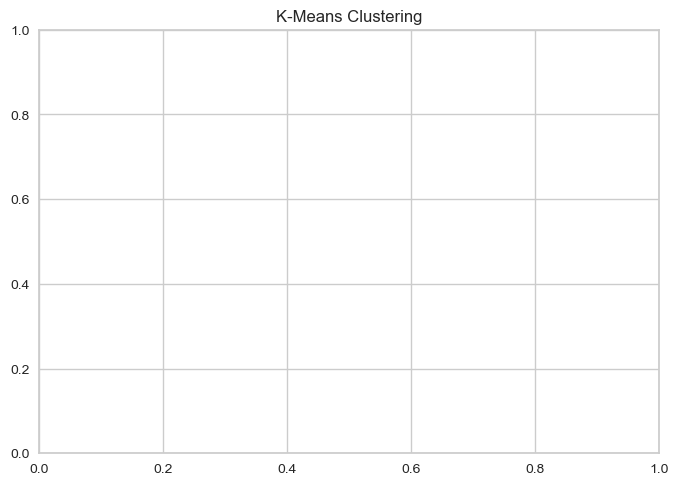

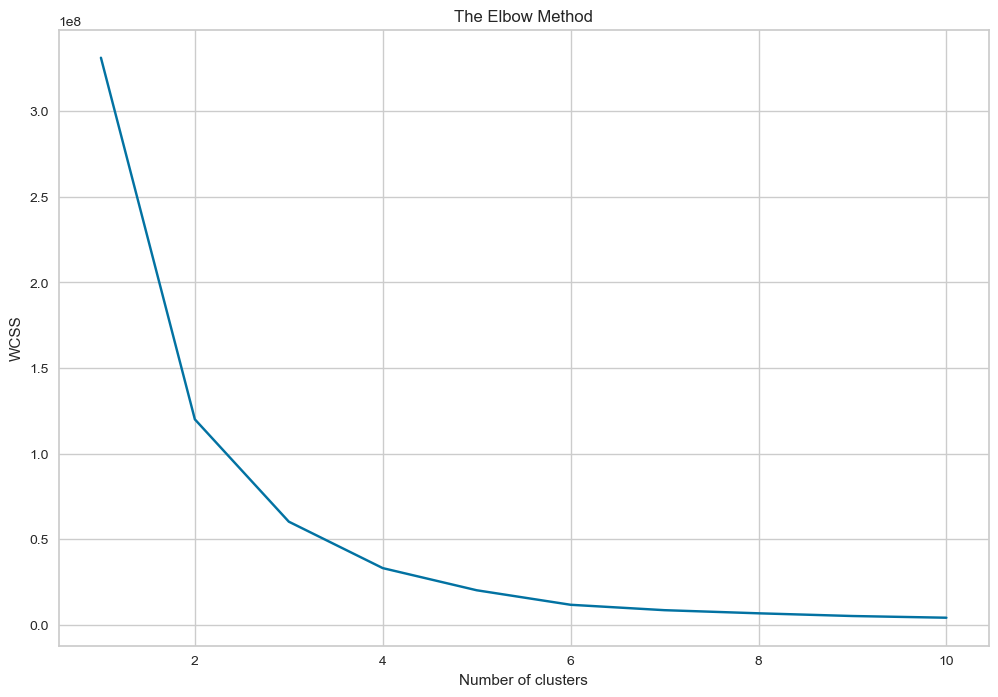

2023-12-10 13:12:17,520 - INFO - Elbow Method completed
2023-12-10 13:12:17,521 - INFO - Saving Inertia and combined score
2023-12-10 13:12:17,571 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.20284
Inertia,4076305.3058


2023-12-10 13:12:24,266 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

2023-12-10 13:12:24,291 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



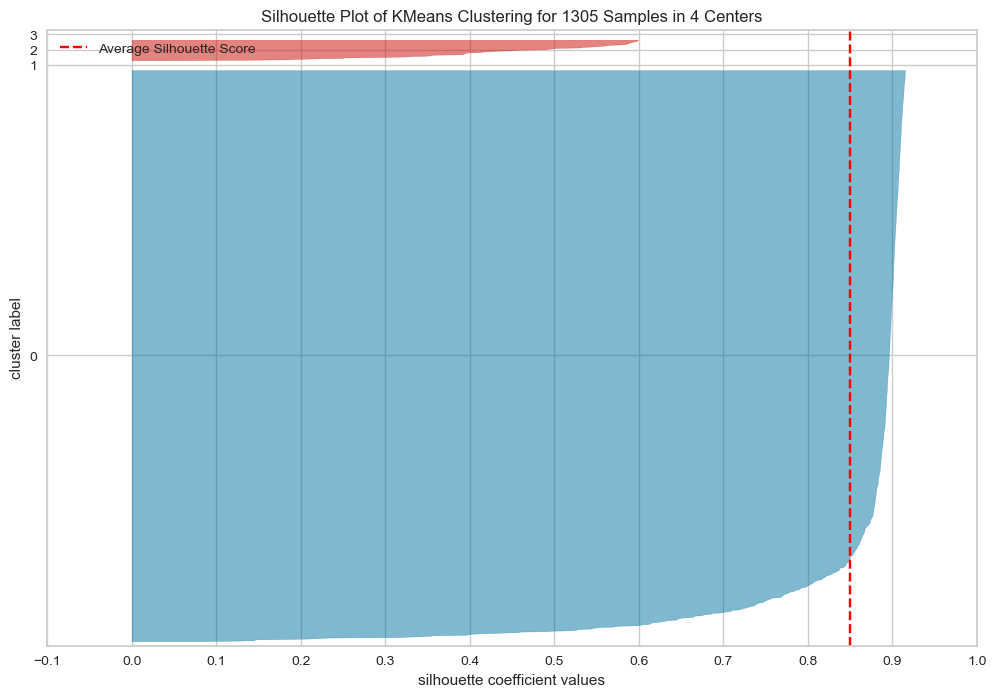

2023-12-10 13:12:25,048 - INFO - Clustering completed
2023-12-10 13:12:25,051 - INFO - Starting plot_clusters function...
2023-12-10 13:12:25,118 - INFO - Saving clusters plot...
2023-12-10 13:12:27,103 - INFO - Cluster plotting completed.
2023-12-10 13:12:27,105 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,4
Silhouette Score,0.84948


wandb: Agent Starting Run: vplkh60g with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 5
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:12:47,281 - INFO - Preparing data...
2023-12-10 13:12:47,558 - INFO - Data prepared successfully.
2023-12-10 13:12:47,560 - INFO - Dropping customer id...
2023-12-10 13:12:47,575 - INFO - Customer id dropped successfully.
2023-12-10 13:12:47,576 - INFO - Cleaning data...
2023-12-10 13:12:47,593 - INFO - Data cleaned successfully.
2023-12-10 13:12:47,598 - INFO - Computing frequencies.
2023-12-10 13:12:47,604 - INFO - Computing monetary values.
2023-12-10 13:12:47,609 - INFO - Computing recency.
2023-12-10 13:12:47,626 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:12:47,632 - INFO - Dataframes concatenated successfully.
2023-12-10 13:12:47,633 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:12:58,662 - INFO - Saved Elbow Method plot


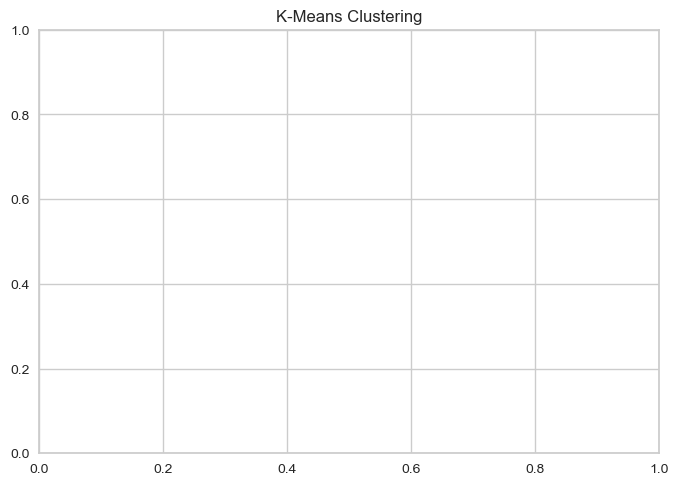

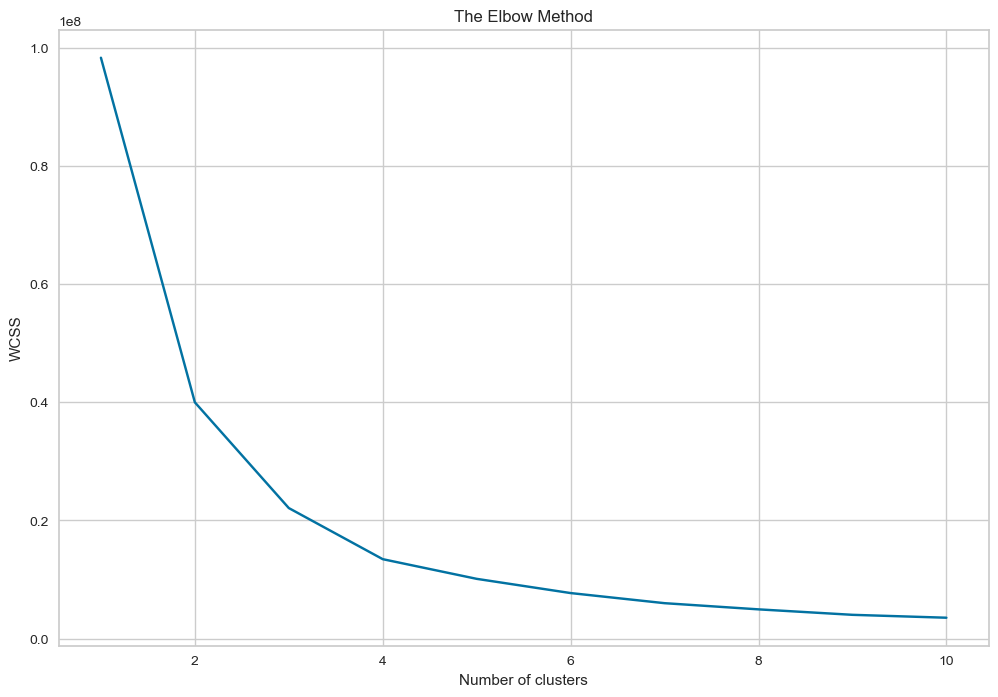

2023-12-10 13:12:59,416 - INFO - Elbow Method completed
2023-12-10 13:12:59,418 - INFO - Saving Inertia and combined score
2023-12-10 13:12:59,457 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.19556
Inertia,3523546.16353


2023-12-10 13:13:06,996 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

2023-12-10 13:13:07,022 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



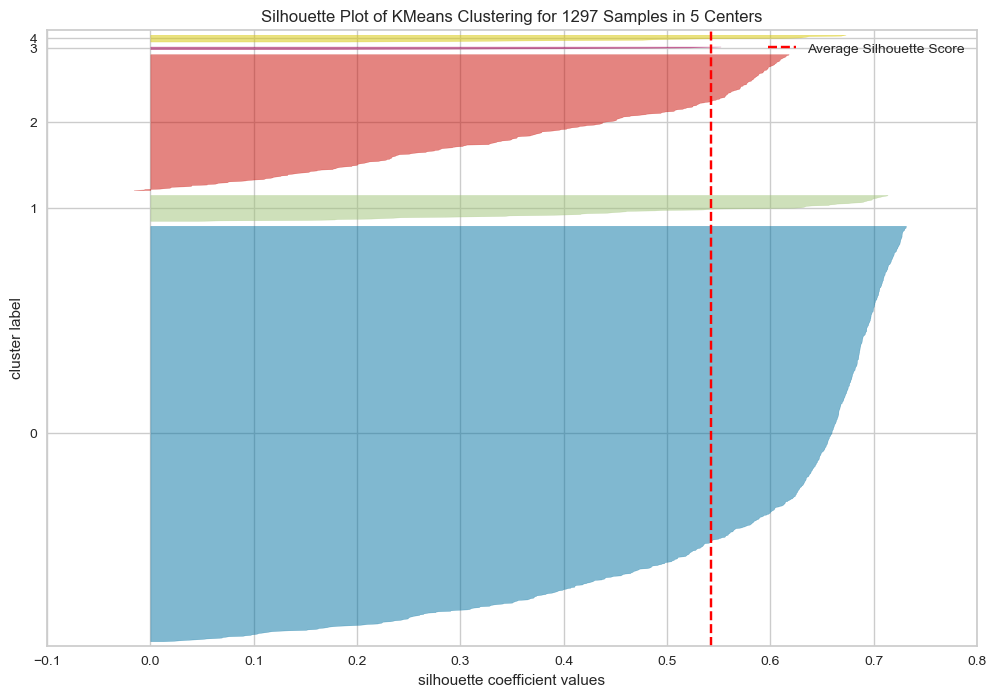

2023-12-10 13:13:07,831 - INFO - Clustering completed
2023-12-10 13:13:07,832 - INFO - Starting plot_clusters function...
2023-12-10 13:13:07,895 - INFO - Saving clusters plot...
2023-12-10 13:13:09,805 - INFO - Cluster plotting completed.
2023-12-10 13:13:09,806 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,5
Silhouette Score,0.5427


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ogijeihz with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 5
wandb: 	random_state: 123
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:13:37,989 - INFO - Preparing data...
2023-12-10 13:13:38,176 - INFO - Data prepared successfully.
2023-12-10 13:13:38,177 - INFO - Dropping customer id...
2023-12-10 13:13:38,189 - INFO - Customer id dropped successfully.
2023-12-10 13:13:38,191 - INFO - Cleaning data...
2023-12-10 13:13:38,202 - INFO - Data cleaned successfully.
2023-12-10 13:13:38,206 - INFO - Computing frequencies.
2023-12-10 13:13:38,211 - INFO - Computing monetary values.
2023-12-10 13:13:38,218 - INFO - Computing recency.
2023-12-10 13:13:38,237 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:13:38,241 - INFO - Dataframes concatenated successfully.
2023-12-10 13:13:38,242 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:13:48,924 - INFO - Saved Elbow Method plot


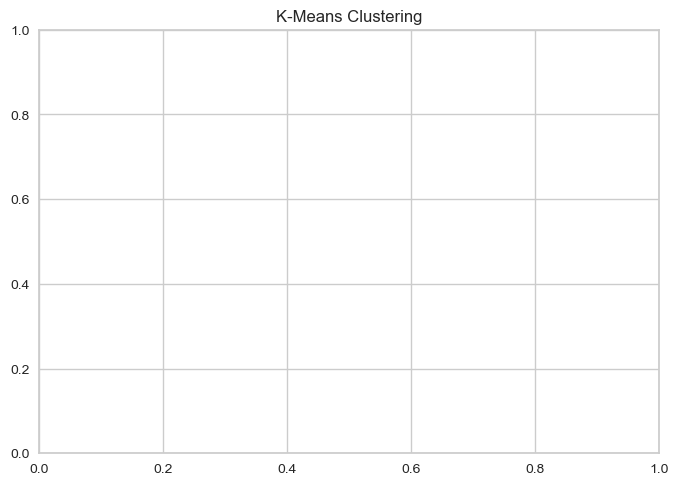

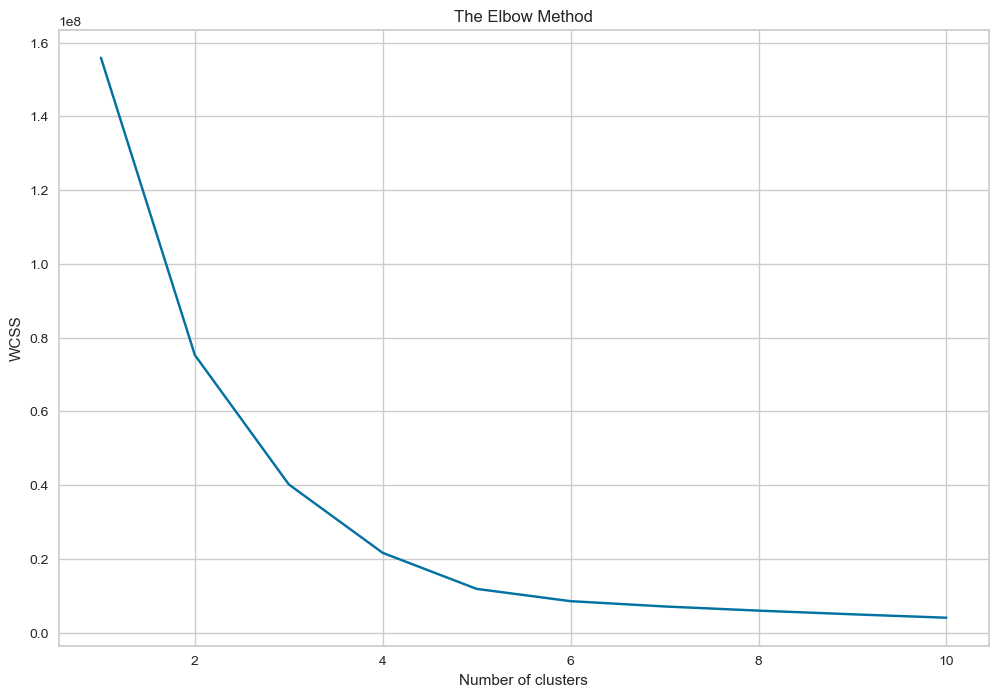

2023-12-10 13:13:49,457 - INFO - Elbow Method completed
2023-12-10 13:13:49,458 - INFO - Saving Inertia and combined score
2023-12-10 13:13:49,492 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.19984
Inertia,4023613.78068


2023-12-10 13:13:56,645 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

2023-12-10 13:13:56,675 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



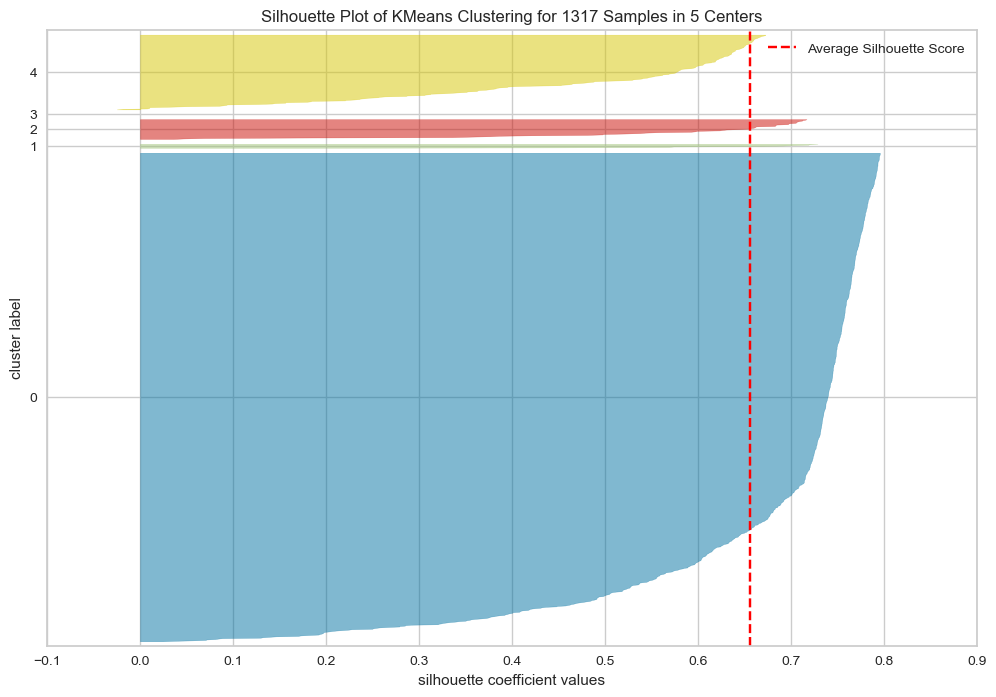

2023-12-10 13:13:57,225 - INFO - Clustering completed
2023-12-10 13:13:57,227 - INFO - Starting plot_clusters function...
2023-12-10 13:13:57,262 - INFO - Saving clusters plot...
2023-12-10 13:13:59,024 - INFO - Cluster plotting completed.
2023-12-10 13:13:59,025 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,5
Silhouette Score,0.65539


wandb: Agent Starting Run: gtk5dqcc with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 5
wandb: 	random_state: 456
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:14:19,801 - INFO - Preparing data...
2023-12-10 13:14:20,110 - INFO - Data prepared successfully.
2023-12-10 13:14:20,112 - INFO - Dropping customer id...
2023-12-10 13:14:20,141 - INFO - Customer id dropped successfully.
2023-12-10 13:14:20,143 - INFO - Cleaning data...
2023-12-10 13:14:20,162 - INFO - Data cleaned successfully.
2023-12-10 13:14:20,167 - INFO - Computing frequencies.
2023-12-10 13:14:20,175 - INFO - Computing monetary values.
2023-12-10 13:14:20,185 - INFO - Computing recency.
2023-12-10 13:14:20,223 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:14:20,230 - INFO - Dataframes concatenated successfully.
2023-12-10 13:14:20,232 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:14:30,256 - INFO - Saved Elbow Method plot


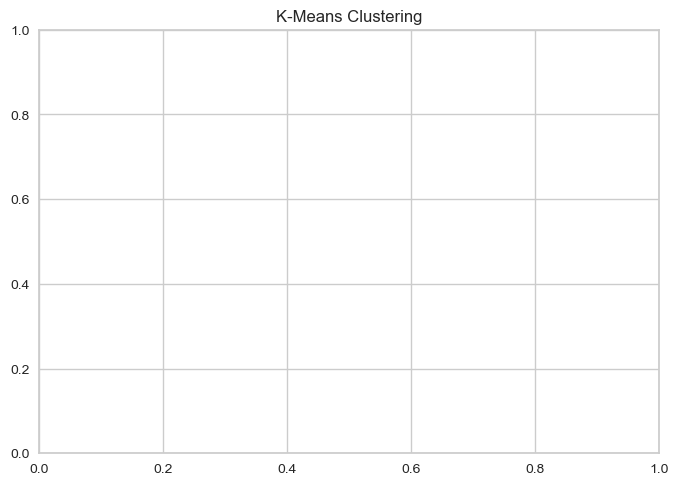

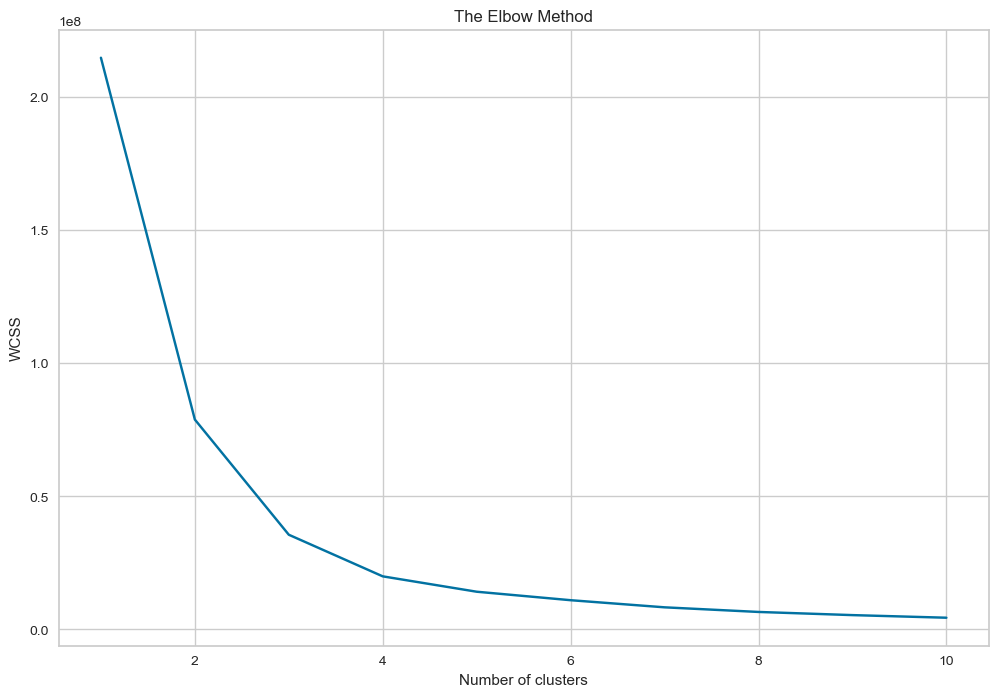

2023-12-10 13:14:30,703 - INFO - Elbow Method completed
2023-12-10 13:14:30,705 - INFO - Saving Inertia and combined score
2023-12-10 13:14:30,740 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.1976
Inertia,4406842.87347


2023-12-10 13:14:38,205 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

2023-12-10 13:14:38,237 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



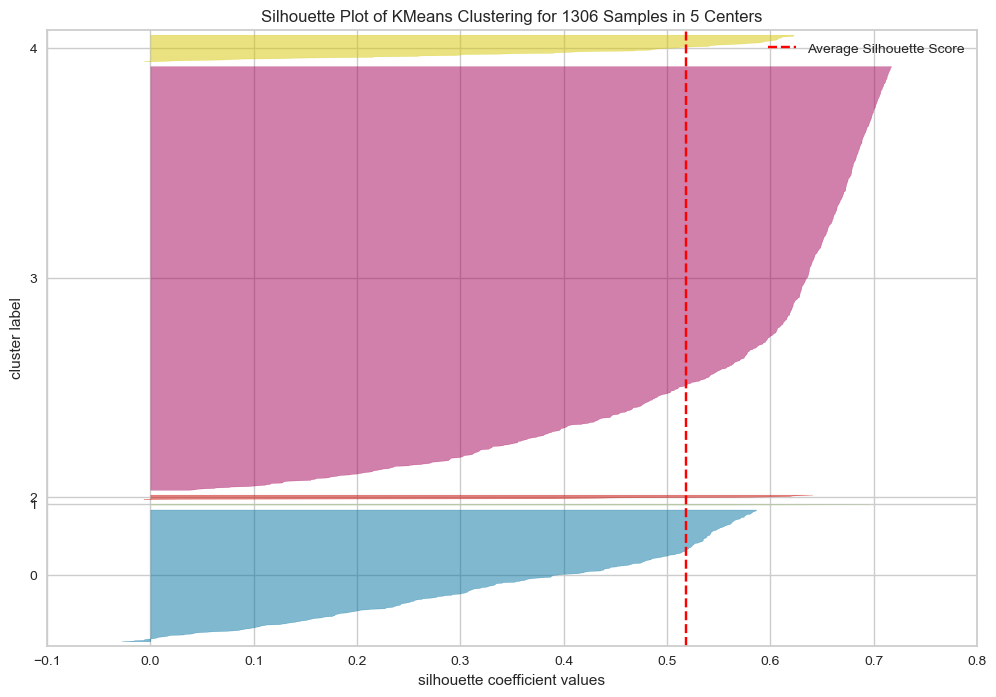

2023-12-10 13:14:38,761 - INFO - Clustering completed
2023-12-10 13:14:38,762 - INFO - Starting plot_clusters function...
2023-12-10 13:14:38,805 - INFO - Saving clusters plot...
2023-12-10 13:14:40,406 - INFO - Cluster plotting completed.
2023-12-10 13:14:40,408 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,5
Silhouette Score,0.51847


wandb: Agent Starting Run: wud710k2 with config:
wandb: 	algorithm: lloyd
wandb: 	n_clusters: 6
wandb: 	random_state: 42
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:15:02,419 - INFO - Preparing data...
2023-12-10 13:15:02,621 - INFO - Data prepared successfully.
2023-12-10 13:15:02,622 - INFO - Dropping customer id...
2023-12-10 13:15:02,636 - INFO - Customer id dropped successfully.
2023-12-10 13:15:02,637 - INFO - Cleaning data...
2023-12-10 13:15:02,648 - INFO - Data cleaned successfully.
2023-12-10 13:15:02,651 - INFO - Computing frequencies.
2023-12-10 13:15:02,656 - INFO - Computing monetary values.
2023-12-10 13:15:02,660 - INFO - Computing recency.
2023-12-10 13:15:02,674 - INFO - Concatenating recency, monetary, and frequencies dataframes.
2023-12-10 13:15:02,679 - INFO - Dataframes concatenated successfully.
2023-12-10 13:15:02,681 - INFO - Starting Elbow Method
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-12-10 13:15:14,909 - INFO - Saved Elbow Method plot


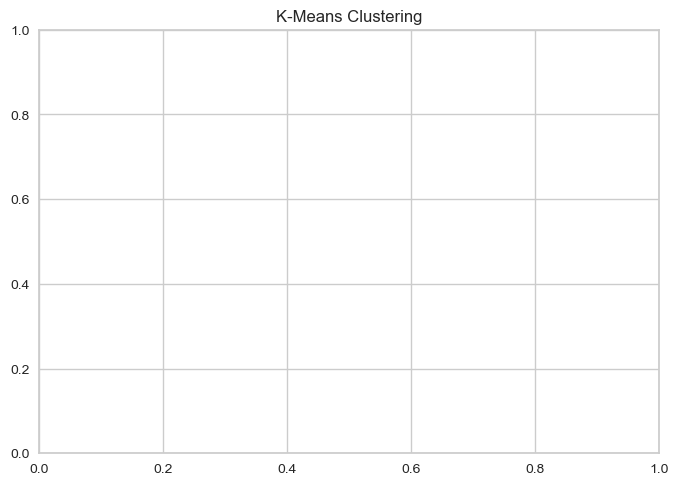

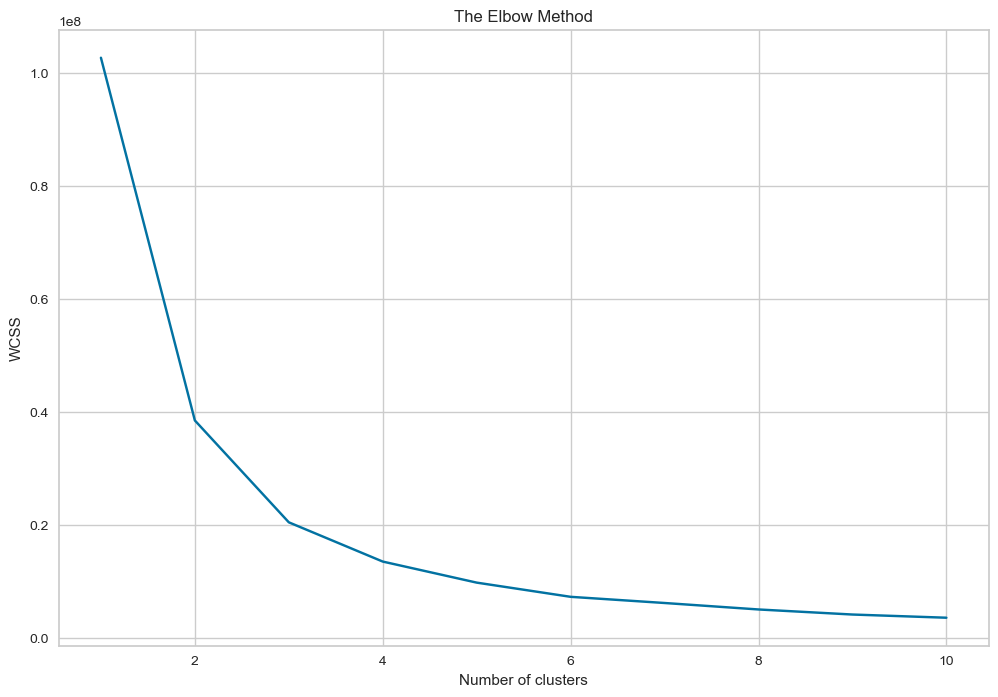

2023-12-10 13:15:16,180 - INFO - Elbow Method completed
2023-12-10 13:15:16,183 - INFO - Saving Inertia and combined score
2023-12-10 13:15:16,236 - INFO - Starting clustering
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Combined Score,▁
Inertia,▁
Combined Score,0.19416
Inertia,3543445.49262


2023-12-10 13:15:23,378 - INFO - Saving Silhouette Score
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

2023-12-10 13:15:23,413 - INFO - Saved Feature Plot
c:\Users\39339\anaconda3\envs\devops_env\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



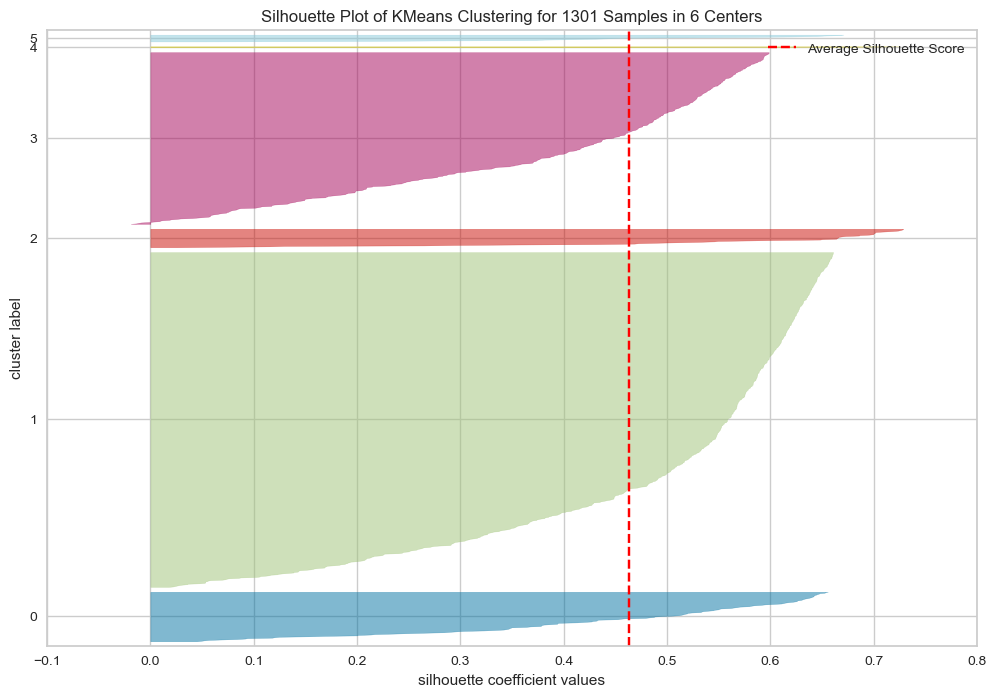

2023-12-10 13:15:24,150 - INFO - Clustering completed
2023-12-10 13:15:24,152 - INFO - Starting plot_clusters function...
2023-12-10 13:15:24,212 - INFO - Saving clusters plot...
2023-12-10 13:15:26,428 - INFO - Cluster plotting completed.
2023-12-10 13:15:26,429 - INFO - Saving plot...


Number of Clusters,▁
Silhouette Score,▁
Clustering Algorithm,lloyd
Number of Clusters,6
Silhouette Score,0.46313


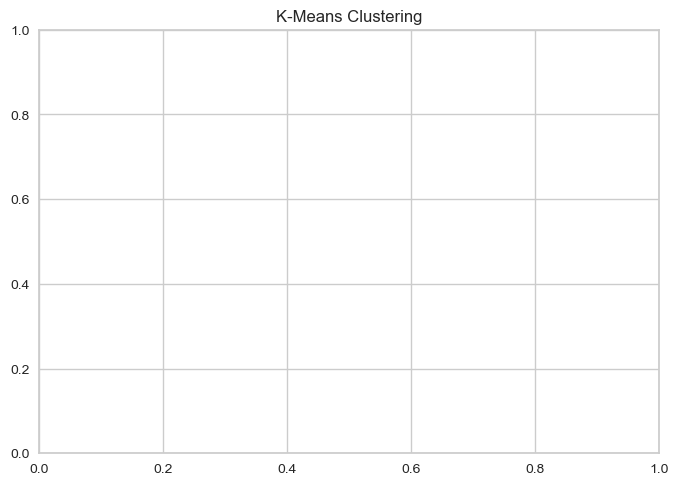

Error in callback <function _WandbInit._pause_backend at 0x00000160D94B91C0> (for post_run_cell):


ConnectionAbortedError: [WinError 10053] Connessione interrotta dal software del computer host

In [1]:
# run_experiment.py
import sys
import json  
import os
import wandb


# Add the path to the src module
current_path = os.getcwd()
data_folder = os.path.abspath(os.path.join(current_path, '..', '..', 'data', 'external'))
data_filepath = os.path.join(data_folder, 'customer_segmentation.csv')
src_path = os.path.abspath(os.path.join(current_path, '..', '..'))
sys.path.append(src_path)

from src.data_preparation.cleaning import *
from src.data_preparation.rfm import *
from src.clustering.kmeans.analysis import * 
from src.clustering.kmeans.core import *
from src.visualization.clustering_visualization import *
from src.visualization.data_visualization import * 

'''
# Initialize WandB
wandb.init(project="Customer_Segmentation", name="Kmeans_Experiment")


# Define sweep configuration
sweep_config_path = os.path.join(os.path.dirname(__file__), 'sweep.yaml')
sweep_id = wandb.sweep(sweep=sweep_config_path, project="Customer_Segmentation")


# Data Prep
df = prepare_data(data_filepath)
df = drop_c_id(df)
df = clean_data(df)

# RFM
frequency = get_frequencies(df)
monetary = get_monetary(df)
recency = get_recency(df)
rfm_dataset = concatenate_dataframes_(recency, monetary, frequency)


# KMeans
X = elbow_method(rfm_dataset)[0]
best_params = get_best_kmeans_params(X)

rfmcopy = choose(rfm_dataset, X)[0]
nclusterskmeans = choose(rfm_dataset, X)[1]
plot_clusters(rfmcopy, clusters1=nclusterskmeans)

silscores = {}
silscores['kmeans'] = silhouette_score_f(X, rfmcopy, 'kmeans_cluster')

wandb.finish()

''' 
sweep_config = {
    "name": "kmeans-sweep",
    "method": "grid",
    "metric": {"goal": "maximize", "name": "Silhouette Score"},
    "parameters": {
        "n_clusters": {"values": [3, 4, 5, 6]},
        "algorithm": {"values": ["lloyd", "elkan"]},
        "random_state": {"values": [42, 123, 456]}
    }
}

def objective():
    # Initialize WandB inside the objective function
    wandb.init(project="Customer_Segmentation", name="Kmeans_Experiment")

    # Paths
    current_path = os.getcwd()
    data_folder = os.path.abspath(os.path.join(current_path, '..', '..', 'data', 'external'))
    data_filepath = os.path.join(data_folder, 'customer_segmentation.csv')

    # Data Prep
    df = prepare_data(data_filepath)
    df = drop_c_id(df)
    df = clean_data(df)

    # RFM
    frequency = get_frequencies(df)
    monetary = get_monetary(df)
    recency = get_recency(df)
    rfm_dataset = concatenate_dataframes_(recency, monetary, frequency)

    # KMeans
    X = elbow_method(rfm_dataset)[0]
    rfm_copy = clustering(wandb.config.n_clusters, wandb.config.algorithm, wandb.config.random_state, X, rfm_dataset)

    #clusters
    plot_clusters(rfm_copy, clusters1=rfm_copy['kmeans_cluster'].nunique())


    wandb.finish()

# The choose function is no longer needed, you can remove it


# Main function
wandb.init(project="Customer_Segmentation", name="Kmeans_Experiment")
def main():
    # Define sweep configuration
    sweep_id = wandb.sweep(sweep=sweep_config, project="Customer_Segmentation")

    # Run the sweep
    wandb.agent(sweep_id, function=objective, count=10)



# Run the main function
if __name__ == "__main__":
    main() 